In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv

sys.path.append('../')
from utils import imshow

%matplotlib inline

# Intensity Transformation and Spatial Filtering

The **spatial domain** is the (height-width) plane containing the pixels of an image. The transformations on spatial
domain usually involve transforming the intensity of a pixel according to the intensity of its neighbours. When the
shape of the neighbourhood is fixed, we move the neighbourhood template (also called mask, kernel, window, or filter)
across the spatial domain, and perform a transformation at each stop. This kind of procedure is called *spatial 
filtering*.

In the simplest case, the neighbourhood consists of only the pixel to be transformed, and the transformation can be
represented as:

$$ s = T(r) $$

where $r, s$ are the intensities of the same pixel before and after the transformation respectively. We call this
kind of procedure *intensity transformation*. For discrete intensities, intensity transformation can be implemented via table lookups.

## Intensity Transformations

### Image Negatives

The negative of an image with intensity levels in range $[0, L - 1]$ is given by:

$$ s = L - 1 - r $$

Suited for enhancing white or gray detail embedded in dark regions of an image, especially when the black areas are
dominant in size.

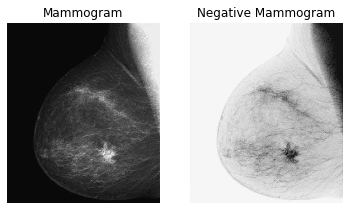

In [2]:
mammogram = cv.imread('../resource/Fig0304(a)(breast_digital_Xray).tif', 
                      cv.IMREAD_GRAYSCALE)

# Grayscale image has 2**8 grayscales.
negative_mammogram = 2 ** 8 - 1 - mammogram

# Plot these two images side by side.
imshow(mammogram, 121, title='Mammogram')
imshow(negative_mammogram, 122, title='Negative Mammogram')

plt.show()

### Log Transformations

The general form of log transformation is:

$$ s = c\log(1 + r) $$

where $r \ge 0$

**Characteristic:**
* map a narrow range of low intensity values into a wider range.
* map a wide range of high intensity values into a narrower range.

Suited for expanding the values of dark pixels while compressing the higher-level values.

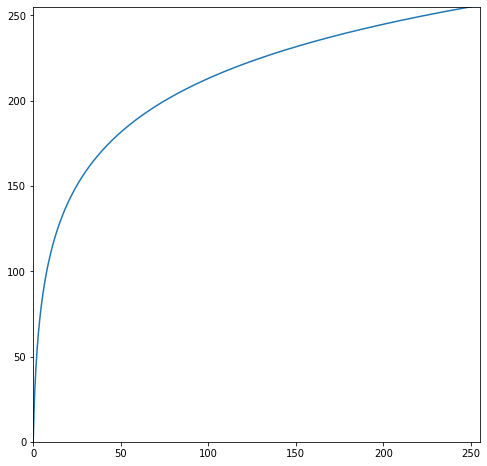

In [17]:
r = np.linspace(0, 255, 1000)
c = 256 / 8

plt.figure(figsize=(8, 8))
plt.axis([0, 255, 0, 255])
plt.plot(r, c * np.log2(1 + r))
plt.show()

### Gamma Transformations

The general form of gamma (power-law) transformation (also called *gamma correction*) is:

$$ s = c\, r^\gamma $$

where $c, \gamma$ are positive constants.

**Note:** 
* In order to keep the intensity range invariant, we can scale the grayscale value into interval `[0, 1]` (e.g. divide by 255) before the gamma transformation and then scale it back (e.g. multiply by 255) after the transformation.

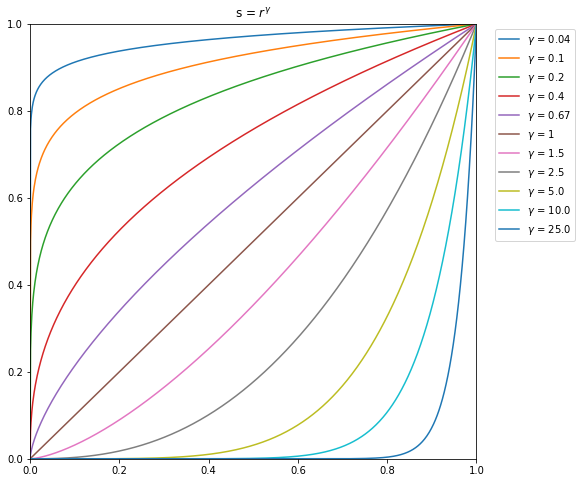

In [7]:
xs = np.linspace(0, 1, 1000)

gammas = (0.04, 0.10, 0.20, 0.40, 0.67, 1, 1.5, 2.5, 5.0, 10.0, 25.0)

plt.figure(figsize=(8, 8))
plt.axis([0, 1, 0, 1])
plt.title('s = $r^\gamma$')
for gamma in gammas:
    plt.plot(xs, np.power(xs, gamma), label=f'$\gamma$ = {gamma}')
plt.legend(bbox_to_anchor=(1.03, 1))
plt.show()

From the above figure, we can see that when $\gamma < 1.0$ the gamma transformation:

* maps a narrow range of low intensity values into a wider range.
* maps a wide range of high intensity values into a narrower range.

This is just like the log transformation. But when $\gamma > 1.0$ the gamma transformation has the
opposite effects.

In [1]:
def gamma_correct(image, gamma=1.0):
    """Perform the gamma correction on image.

    Note: currently, it only supports transformations for grayscale
    images.

    Parameters
    ----------
    image: 2-dim ndarray
        The input grayscale image.
    gamma: nonnegative float
        Gamma value.
    Returns
    -------
    2-dim ndarray
        Gamma corrected image with the same shape as input image.
    """
    # Sanity checks.
    if gamma < 0.0:
        raise ValueError('Gamma value should be non-negative')
    if gamma == 1.0:
        return image
    
    # Gamma transformation lookup talbe.
    L = 256
    lookup_table = np.arange(L, dtype=np.float)
    np.power(lookup_table / (L - 1), gamma, out=lookup_table)
    np.rint(lookup_table * (L - 1), out=lookup_table)
    lookup_table = lookup_table.astype(np.uint8, copy=False)

    return lookup_table[image]

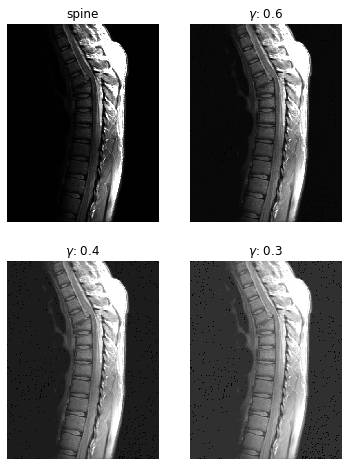

In [48]:
spine = cv.imread('../resource/Fig0308(a)(fractured_spine).tif',
                  cv.IMREAD_GRAYSCALE)

gammas = [1.0, 0.6, 0.4, 0.3]
i = 1
plt.figure(figsize=(6, 8))
for gamma in gammas:
    if i == 1:
        imshow(spine, 221, title='spine')
    else:
        corrected_image = gamma_correct(spine, gamma=gamma)
        imshow(corrected_image, position=(2, 2, i), title=f'$\gamma$: {gamma}')
    i += 1
plt.show()

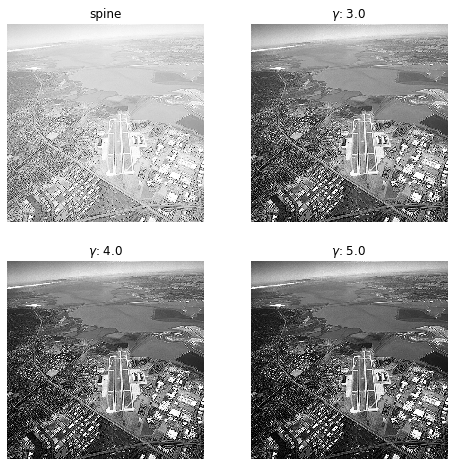

In [51]:
aerial_image = cv.imread('../resource/Fig0309(a)(washed_out_aerial_image).tif',
                         cv.IMREAD_GRAYSCALE)

gammas = [1.0, 3.0, 4.0, 5.0]
i = 1
plt.figure(figsize=(8, 8))
for gamma in gammas:
    if i == 1:
        imshow(aerial_image, 221, title='spine')
    else:
        corrected_image = gamma_correct(aerial_image, gamma=gamma)
        imshow(corrected_image, position=(2, 2, i), title=f'$\gamma$: {gamma}')
    i += 1
plt.show()

### Piecewise-linear Transformations

## Histogram Processing

### Histogram Equalization

### Histogram Matching (Specification)

### Local Histogram Processing

## Spatial Filtering

### Fundamentals

### Smoothing Spatial Filters

### Sharpening Spatial Filters

## Fuzzy Techniques